In [1]:
using DifferentialEquations, Plots, Rsvg, DiffEqProblemLibrary
gr()

Plots.GRBackend()

# Model and example solutions
Here we implement the gene expression model from appendix A.6 of Marchetti, Priami and Thanh, *Simulation Algorithms for Comptuational Systems Biology*, Springer (2017).

In [2]:
jprob = prob_jump_dnadimer_repressor
rn = jprob.network
rnpar = jprob.rates
varlabels = jprob.prob_data["specs_names"]
u0 = jprob.u0
tf = jprob.tstop

4000.0

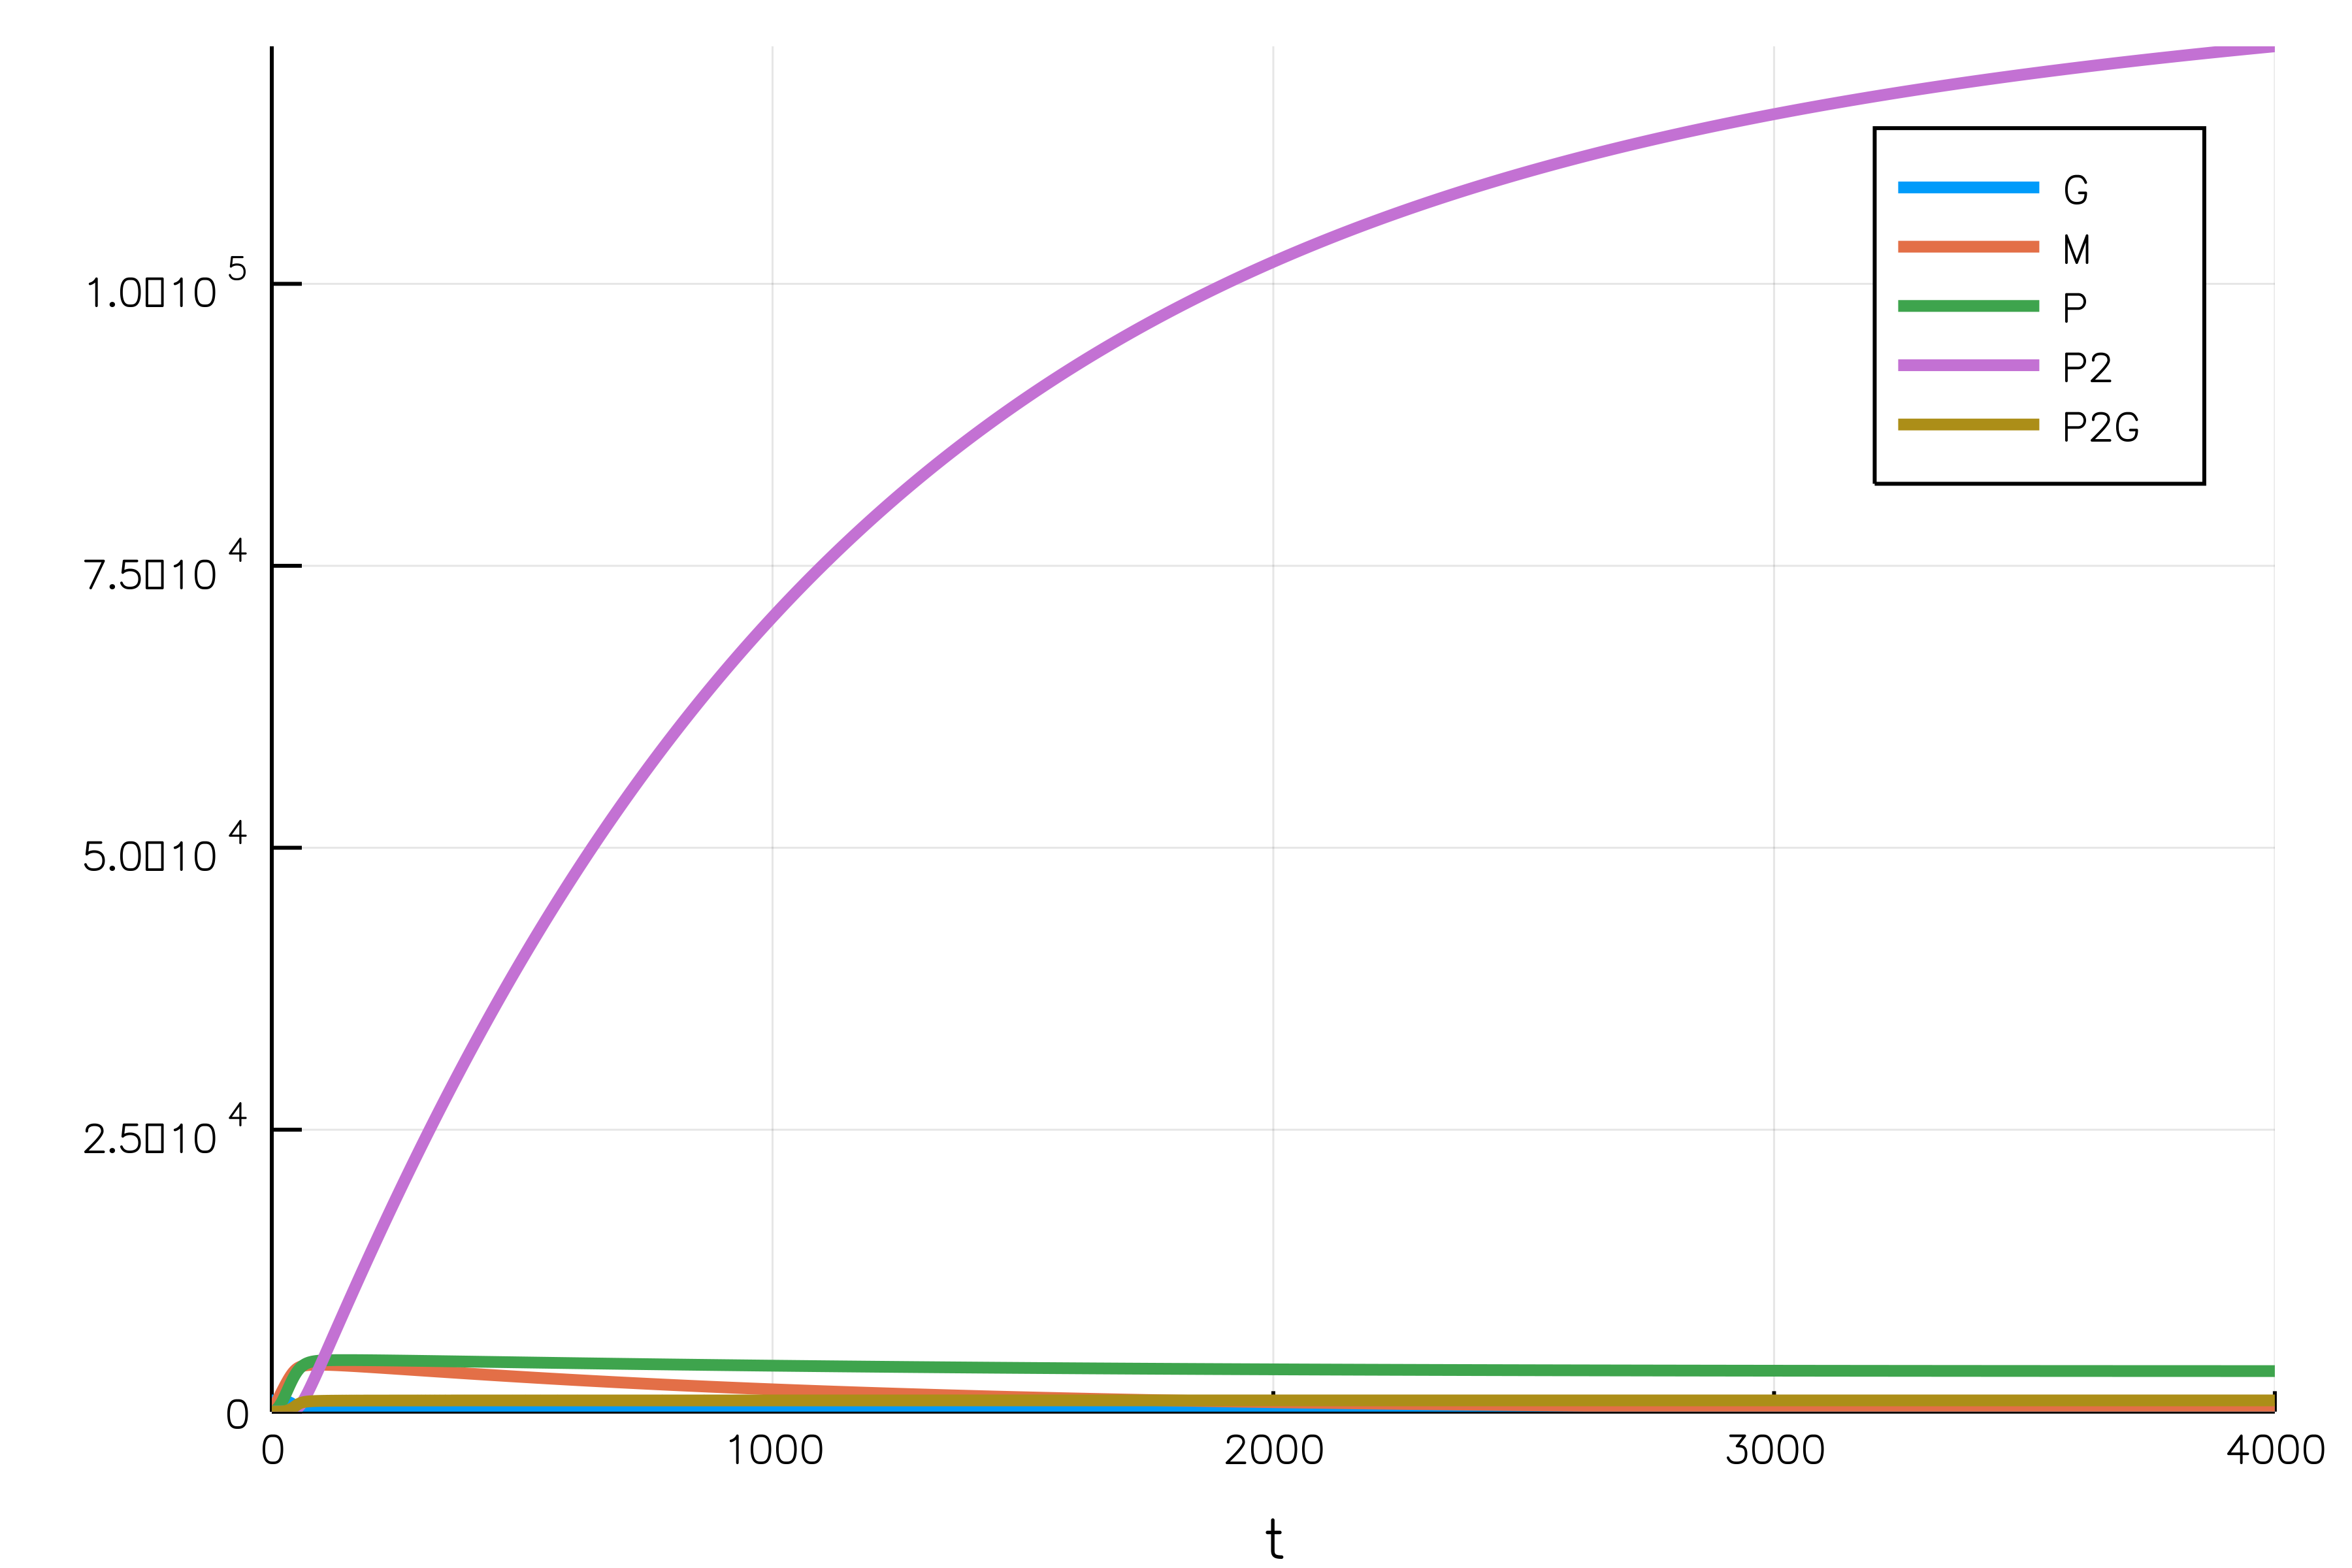

In [3]:
u0f = [1000., 0., 0., 0.,0.]
odeprob = ODEProblem(rn, u0f, (0.,tf),rnpar)
sol = solve(odeprob,Tsit5())
plot(sol, format=:png, label=varlabels)

In [4]:
ssprob = SteadyStateProblem(rn, u0f, rnpar)
ssol = solve(ssprob, DynamicSS(AutoTsit5(Rosenbrock23())))
ssol[:,end]

5-element Array{Float64,1}:
    0.896018 
   80.6416   
 4480.05     
    2.00709e5
  999.104    

In [5]:
ssprob2 = SteadyStateProblem(rn, ssol[:,end], rnpar)
ssol2 = solve(ssprob2,SSRootfind())

u: 5-element Array{Float64,1}:
    0.896011 
   80.641    
 4480.05     
    2.00709e5
  999.096    

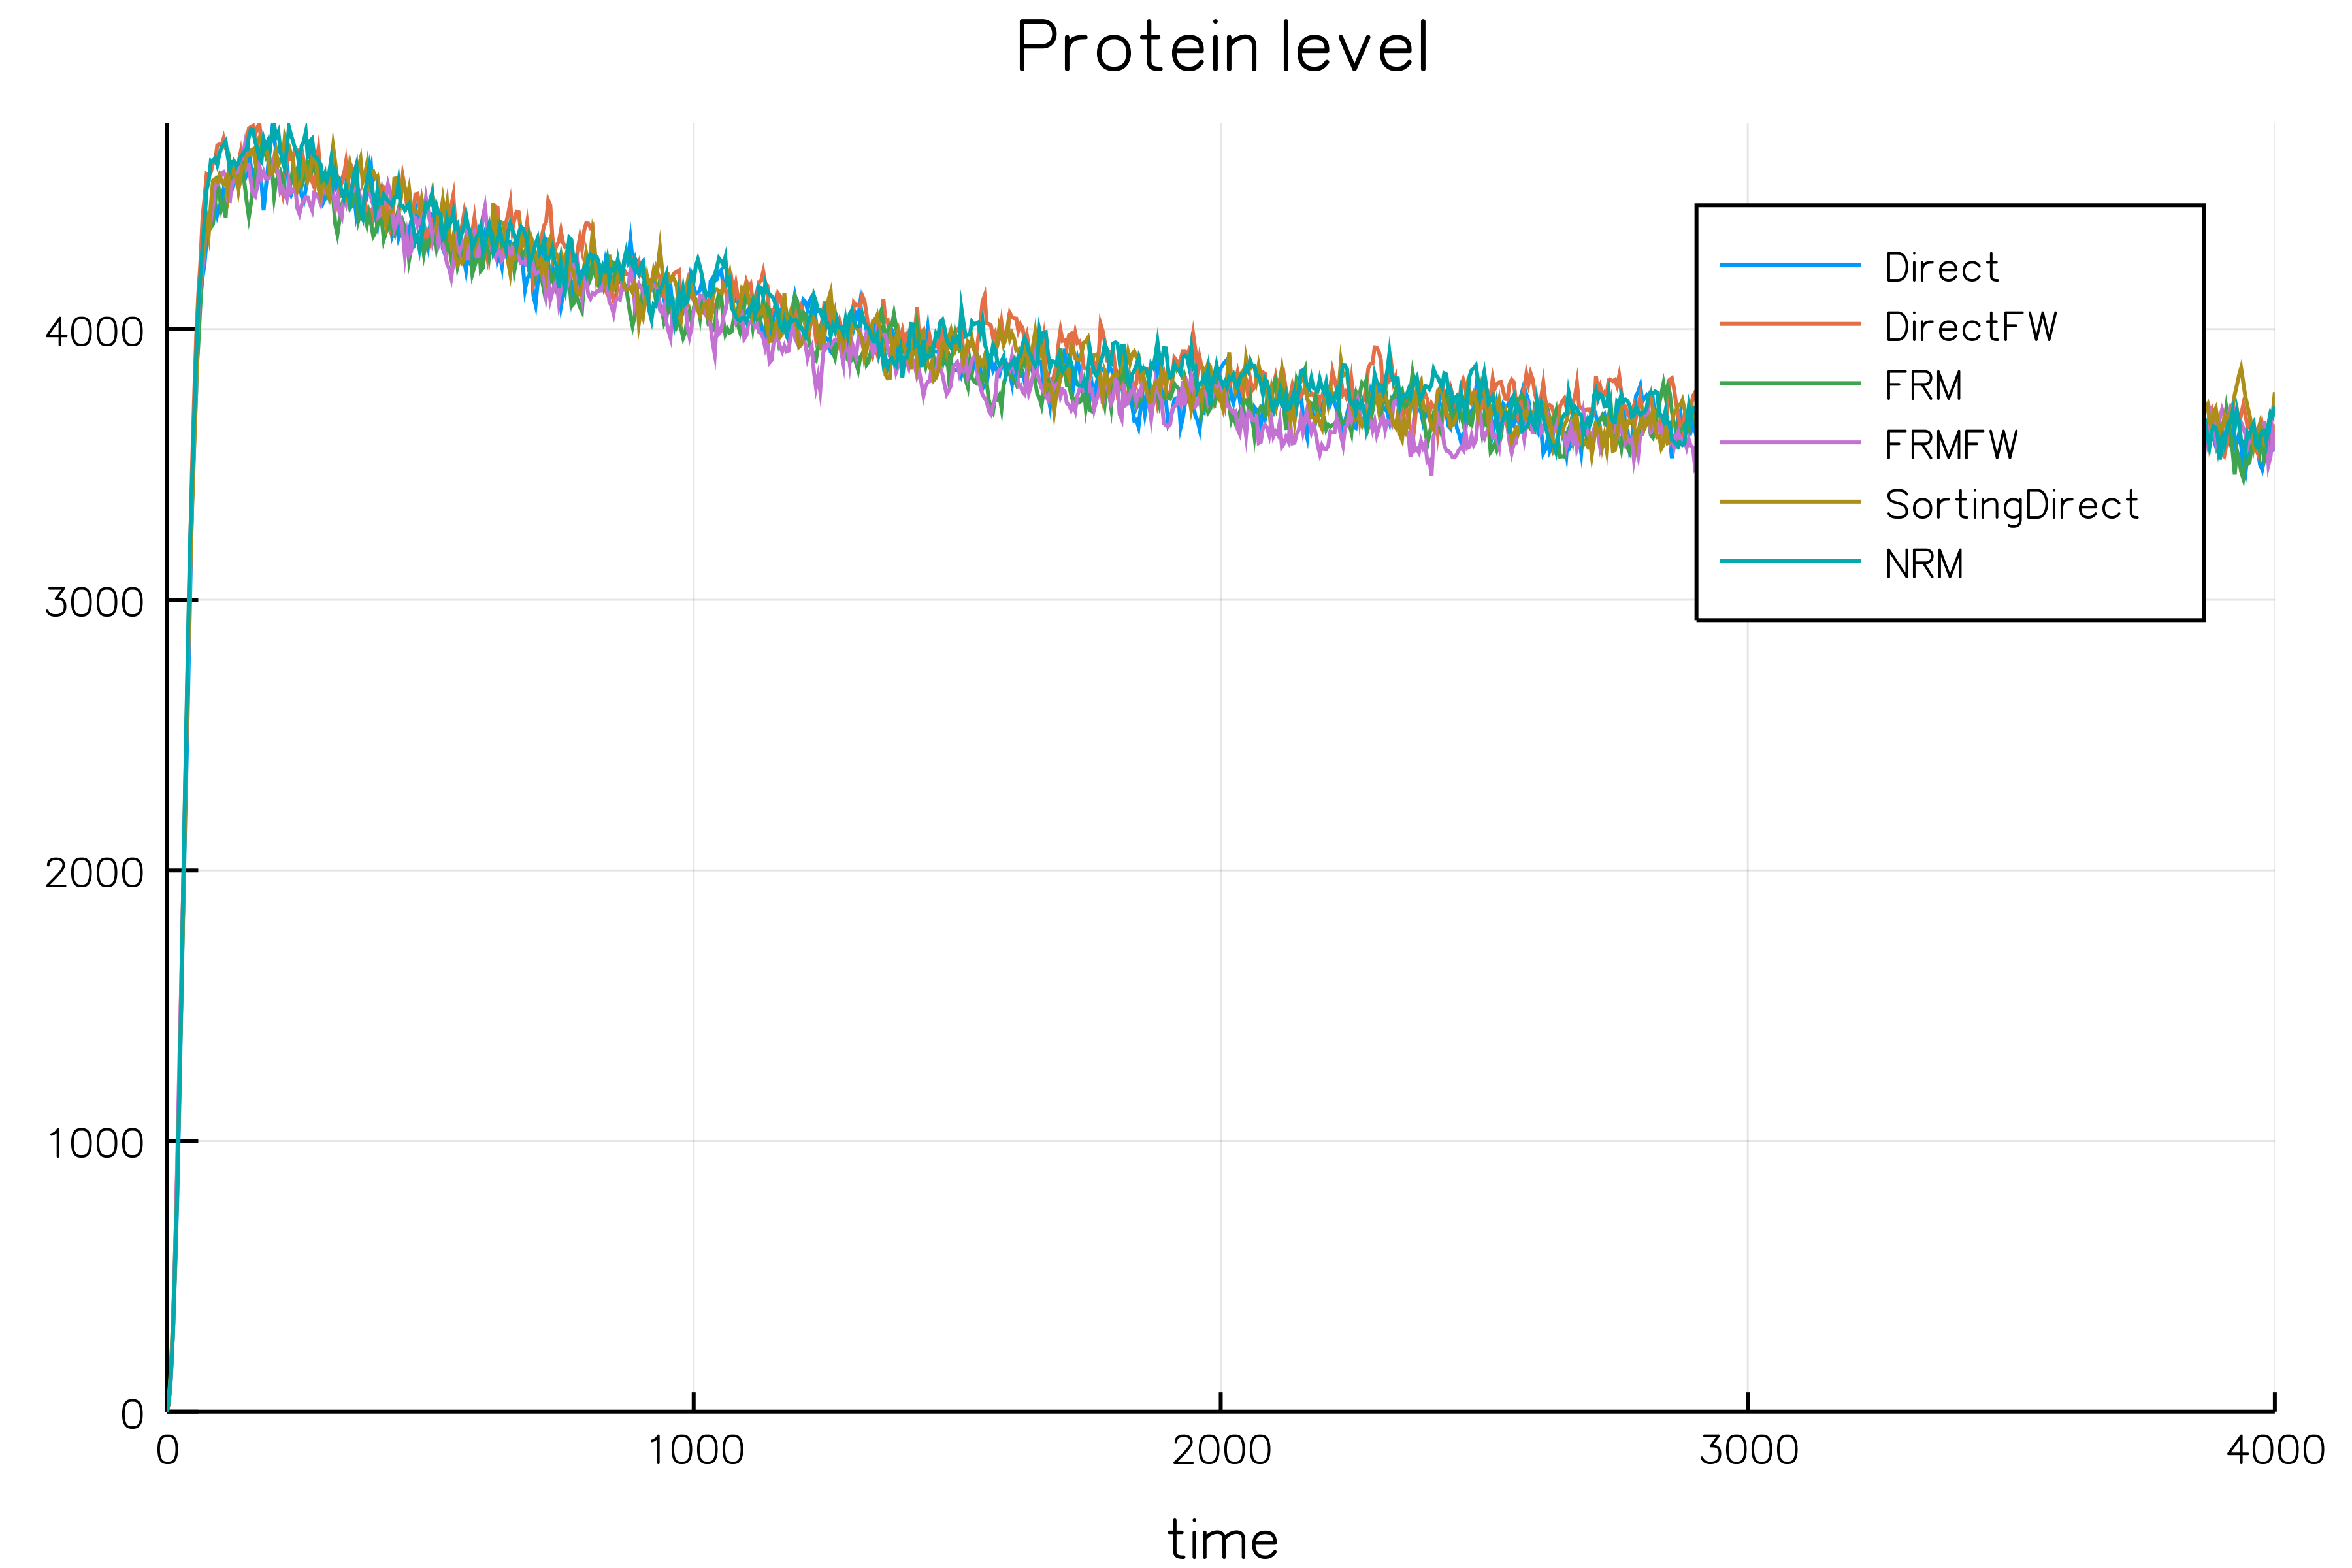

In [3]:
tf      = 4000.
methods = (Direct(),DirectFW(),FRM(),FRMFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
fmt     = :png
prob    = prob = DiscreteProblem(u0, (0.0, tf), rnpar)
ploth   = plot(reuse=false)
p = []
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    plot!(ploth,sol.t,sol[3,:],label=shortlabels[i], format=fmt)
    push!(p, plot(sol,title=shortlabels[i],leg=false,format=fmt))
end
plot(ploth, title="Protein level", xlabel="time",format=fmt)

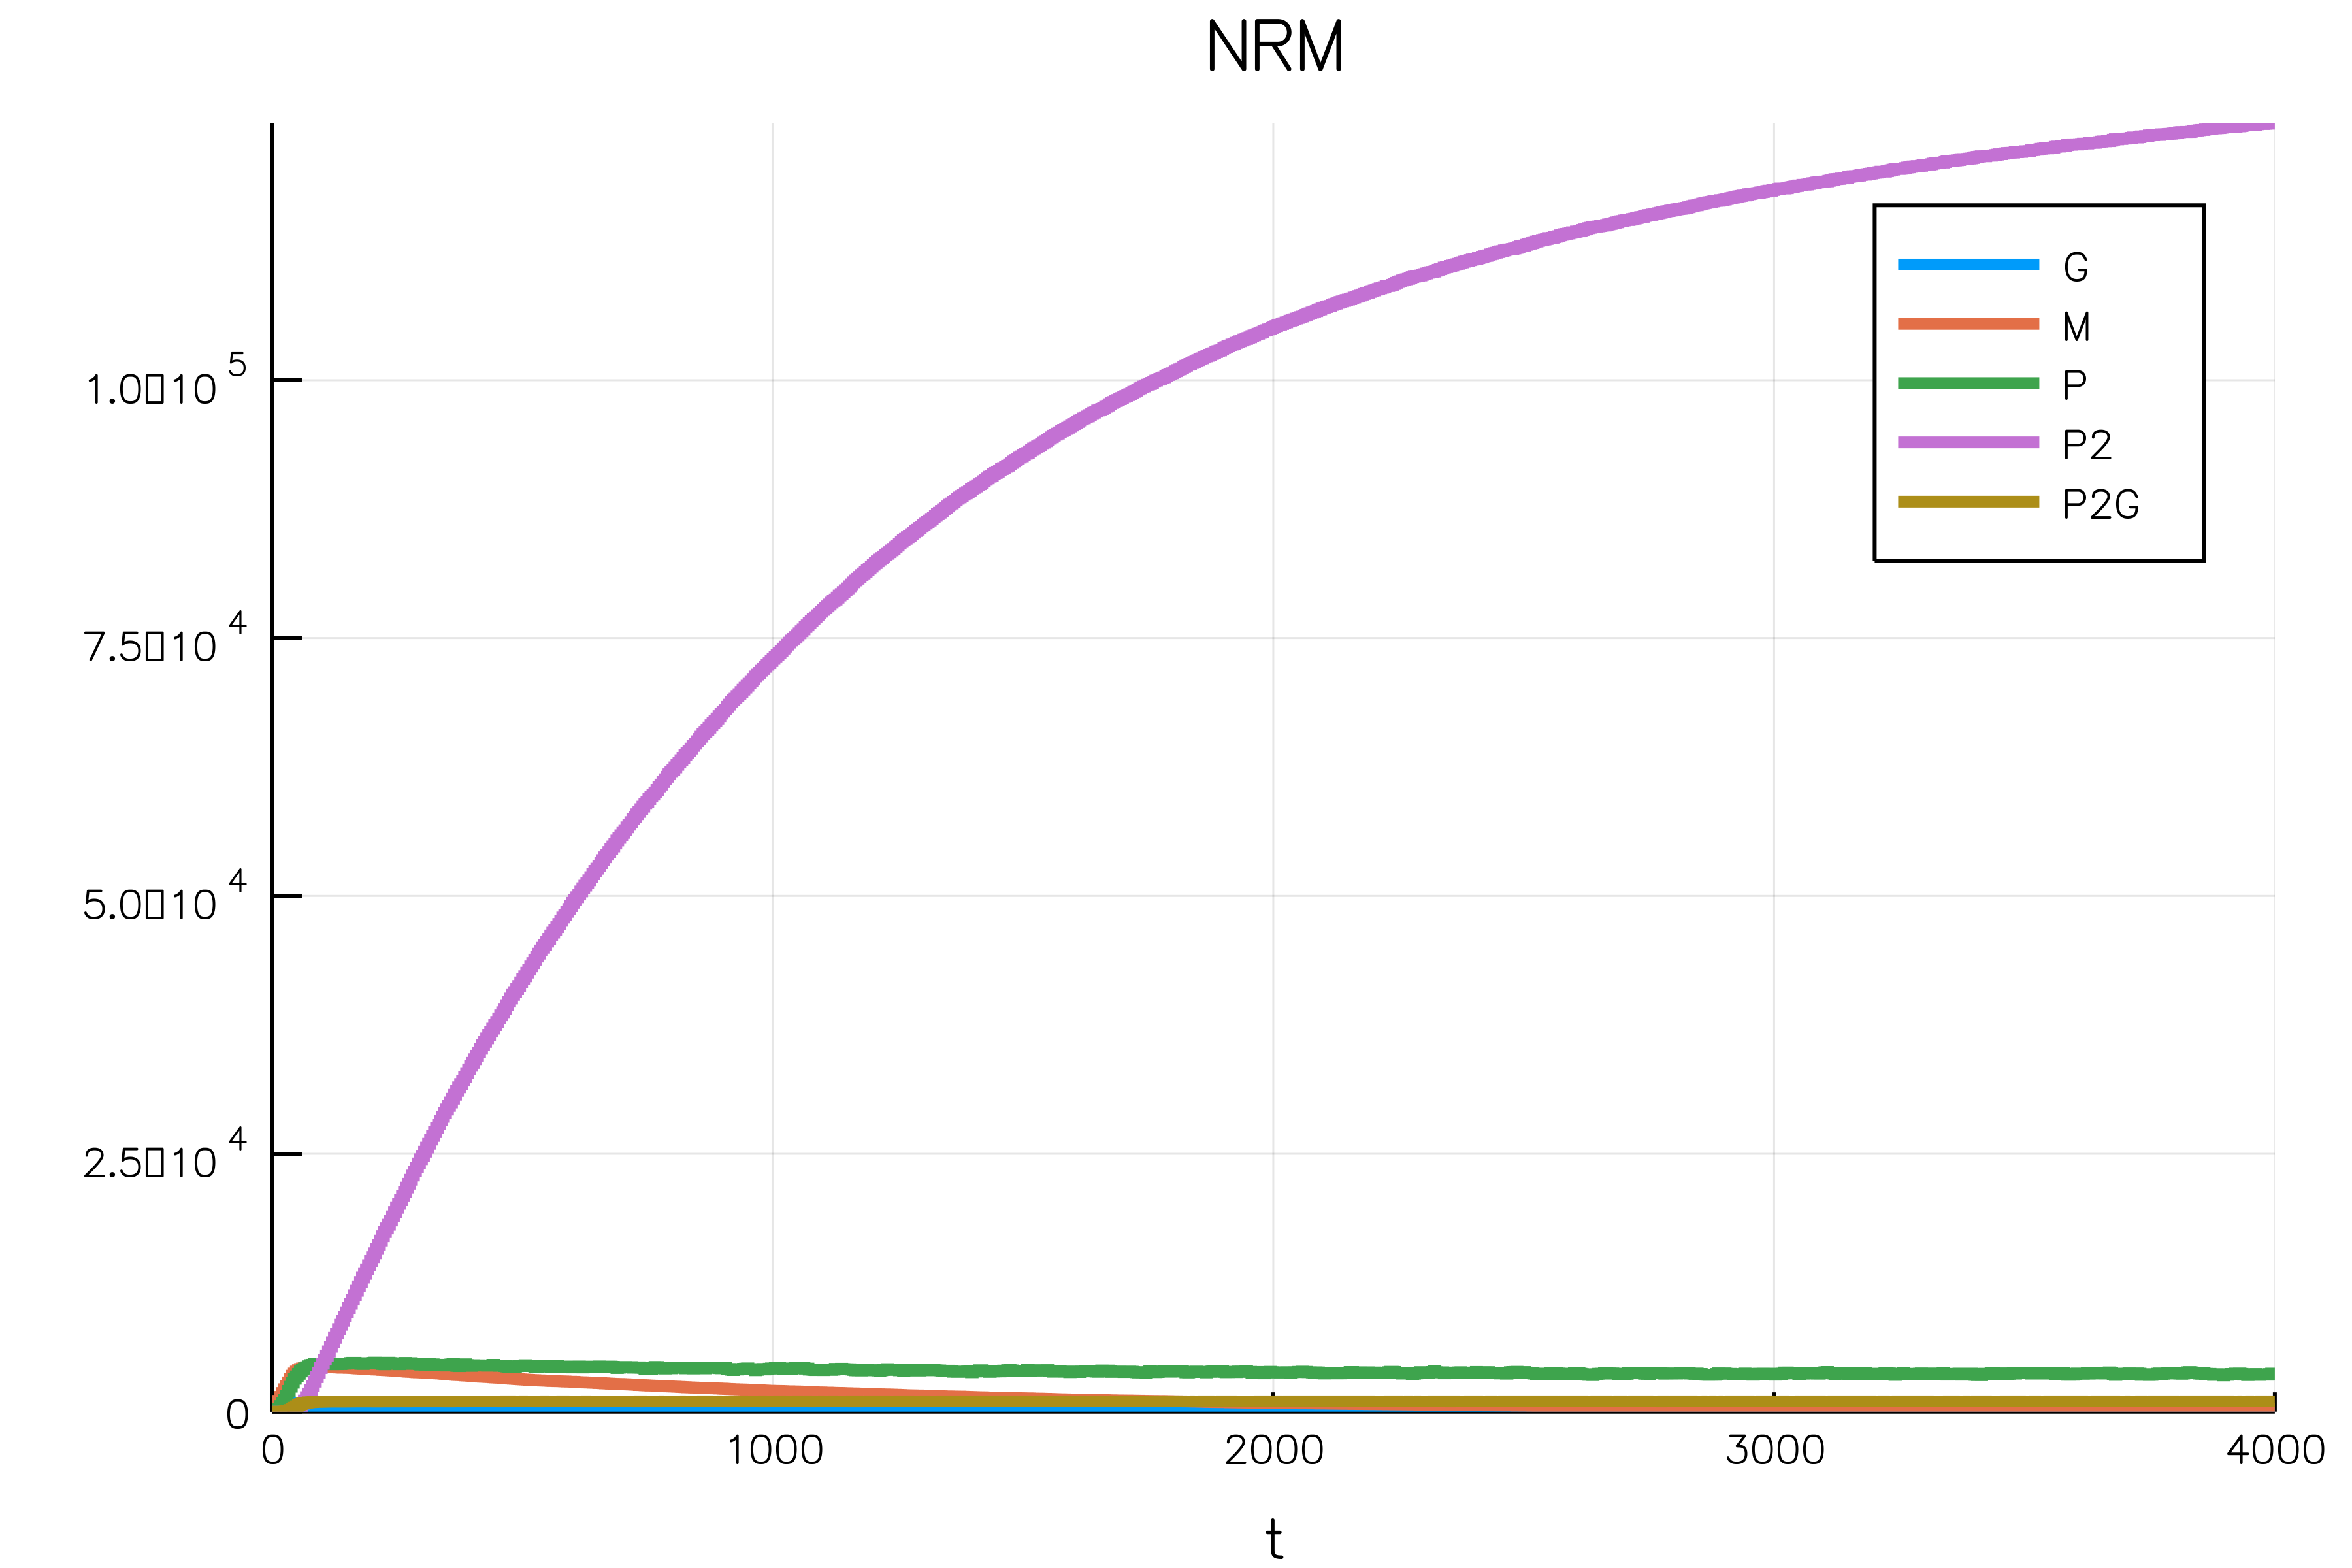

In [4]:
plot(p[end],format=fmt,legend=true,labels=varlabels)

# Benchmarking performance of the methods

In [5]:
function run_benchmark!(t, jump_prob, stepper)
    sol = solve(jump_prob, stepper)
    @inbounds for i in 1:length(t)
        t[i] = @elapsed (sol = solve(jump_prob, stepper))
    end
end

run_benchmark! (generic function with 1 method)

In [10]:
nsims = 50
benchmarks = Vector{Vector{Float64}}()
gc()
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    stepper = SSAStepper()
    t = Vector{Float64}(nsims)
    run_benchmark!(t, jump_prob, stepper)
    push!(benchmarks, t)
end

In [11]:
medtimes = Vector{Float64}(length(methods))
stdtimes = Vector{Float64}(length(methods))
avgtimes = Vector{Float64}(length(methods))
for i in 1:length(methods)
    medtimes[i] = median(benchmarks[i])
    avgtimes[i] = mean(benchmarks[i])
    stdtimes[i] = std(benchmarks[i])
end
using DataFrames

df = DataFrame(names=shortlabels,medtimes=medtimes,relmedtimes=(medtimes/medtimes[1]),avgtimes=avgtimes, std=stdtimes, cv=stdtimes./avgtimes)

,names,medtimes,relmedtimes,avgtimes,std,cv
1,Direct,2.63641,1.0,2.6346,0.0804016,0.0305176
2,DirectFW,2.75872,1.04639,2.76602,0.0864465,0.031253
3,FRM,3.66807,1.39131,3.58893,0.317529,0.0884748
4,FRMFW,3.91567,1.48523,3.87053,0.306865,0.0792825
5,SortingDirect,2.5464,0.965857,2.53215,0.0808972,0.031948
6,NRM,4.67653,1.77382,4.65594,0.27574,0.0592234


Below are `BenchmarkTools` results, they are not always consistent from run to run, so should probably be ignored.

In [12]:
using BenchmarkTools
benchmarks = []
# turn off saving solution
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper())    
    push!(benchmarks, @benchmark (for i = 1:5; solve($jump_prob, $SSAStepper()); end))
end

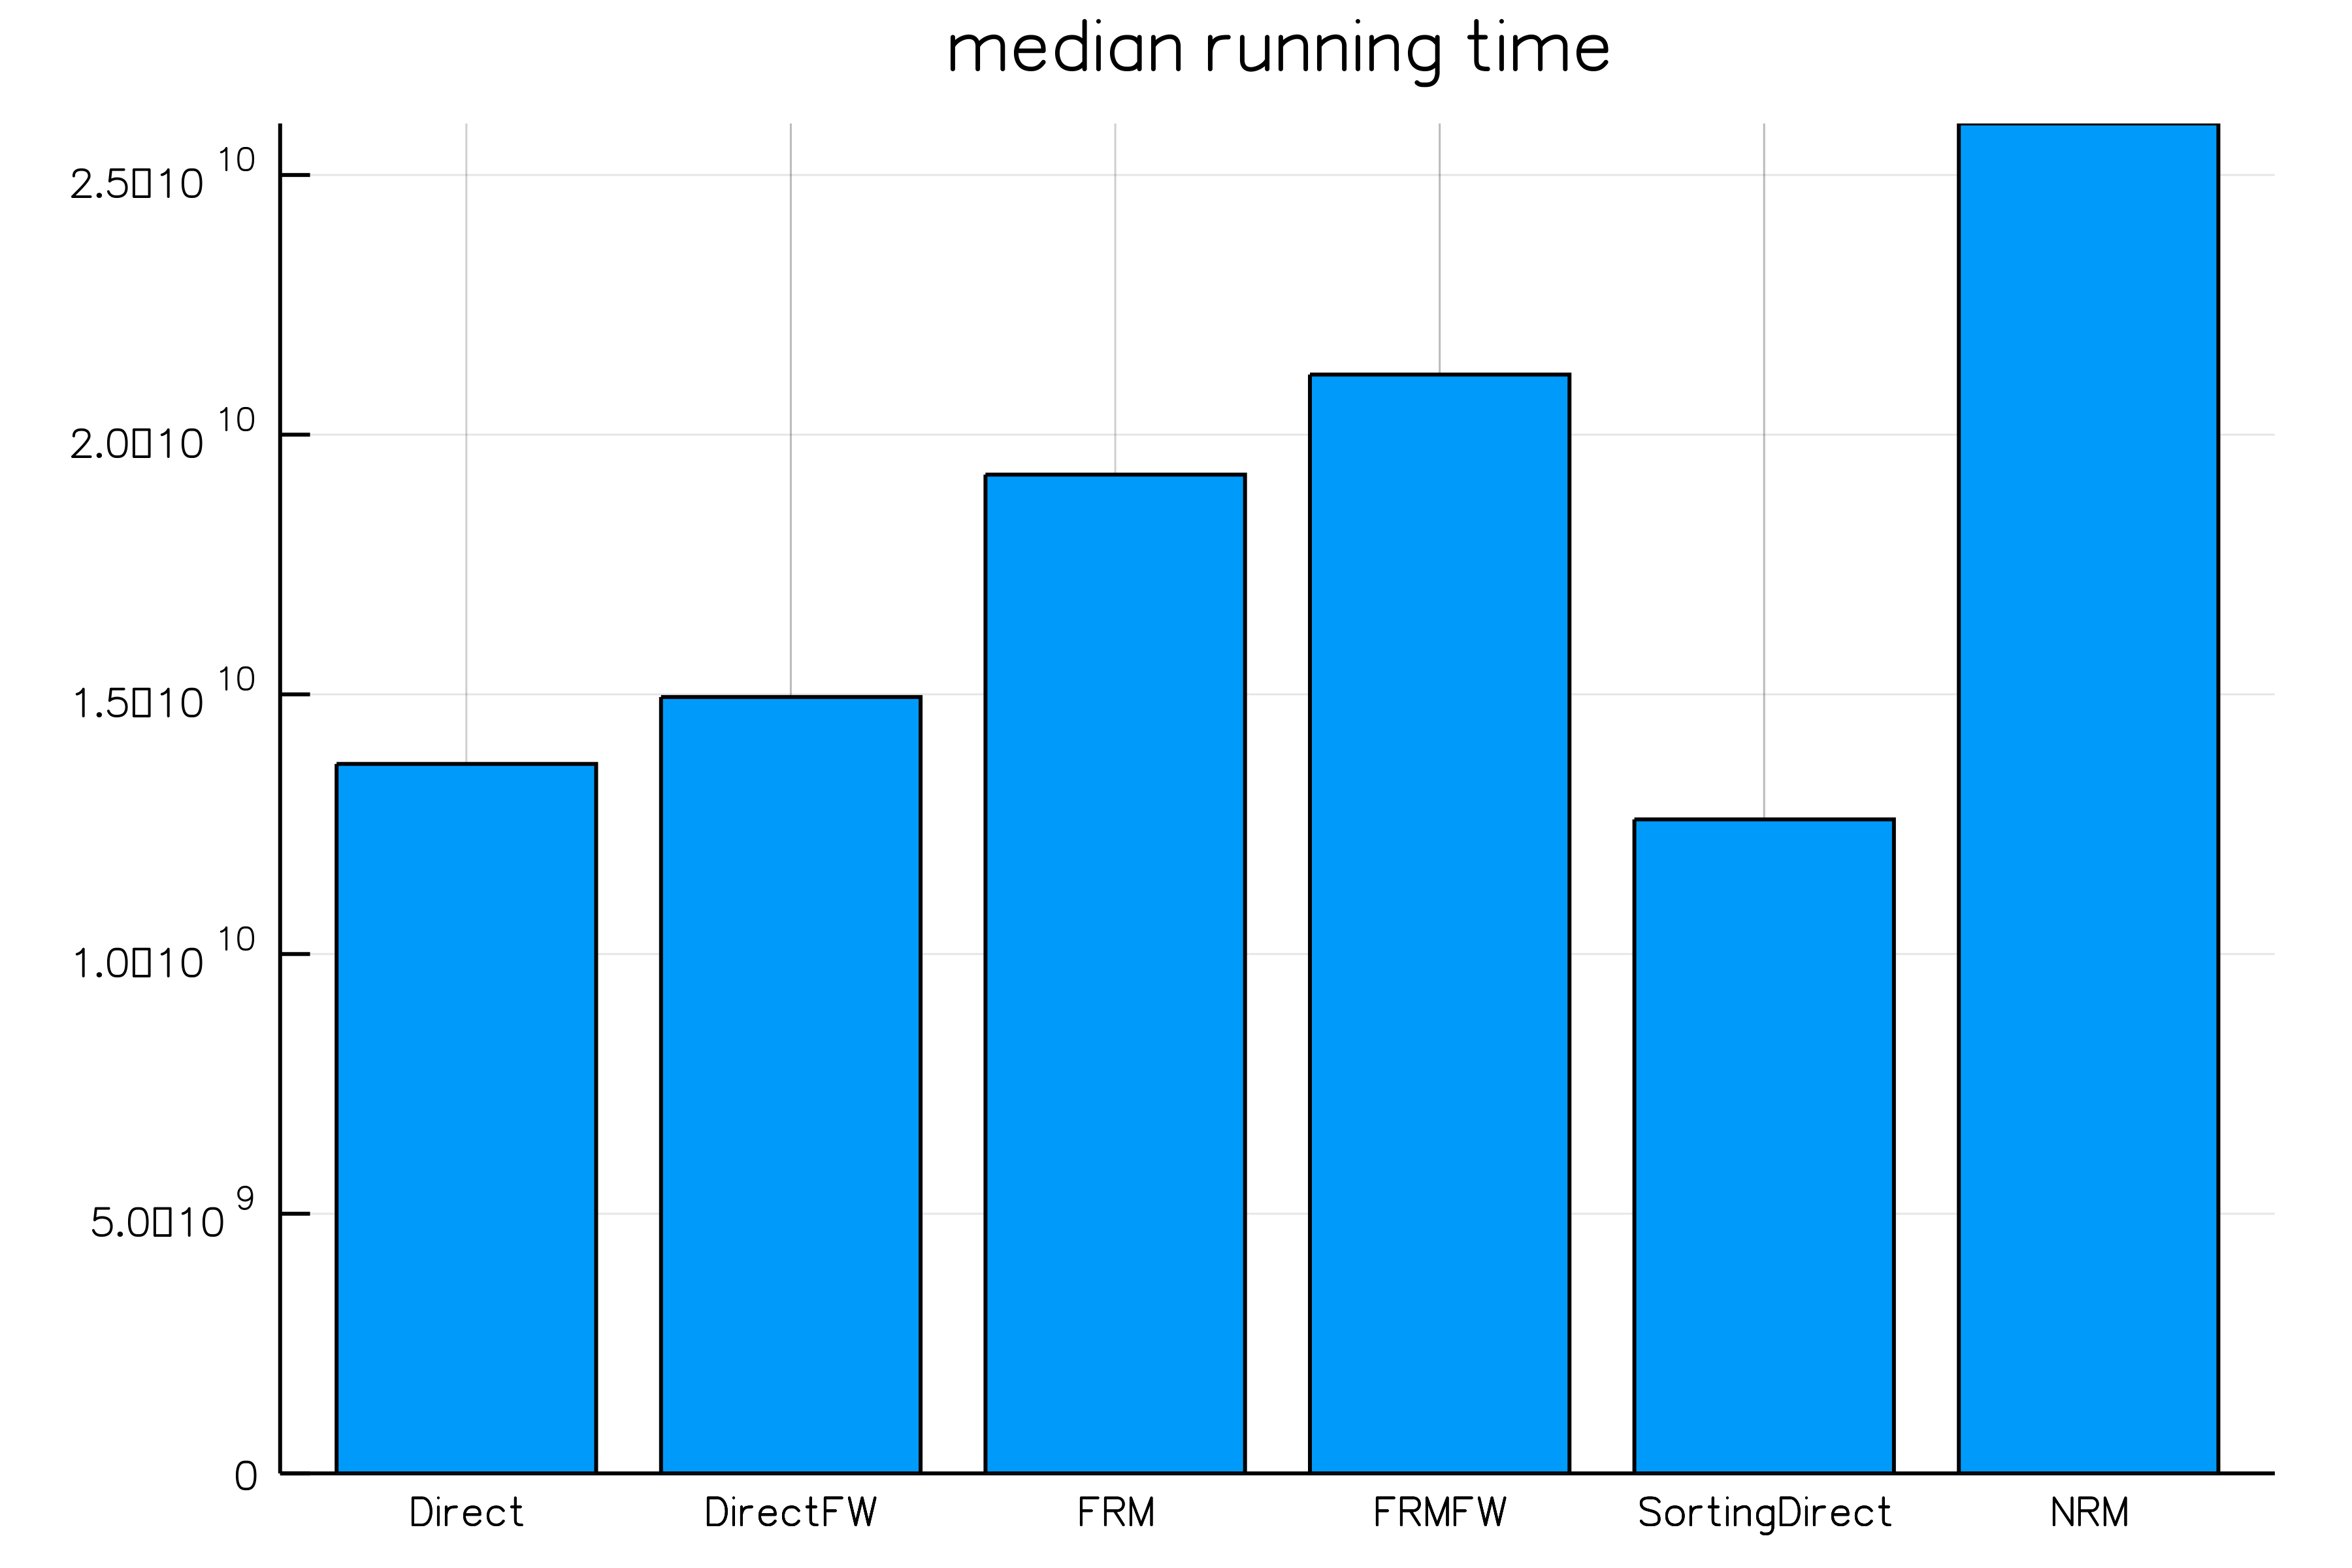

In [13]:
medtimes = [median(b.times) for b in benchmarks]
bar(shortlabels,medtimes,title="median running time",leg=false,format=fmt)

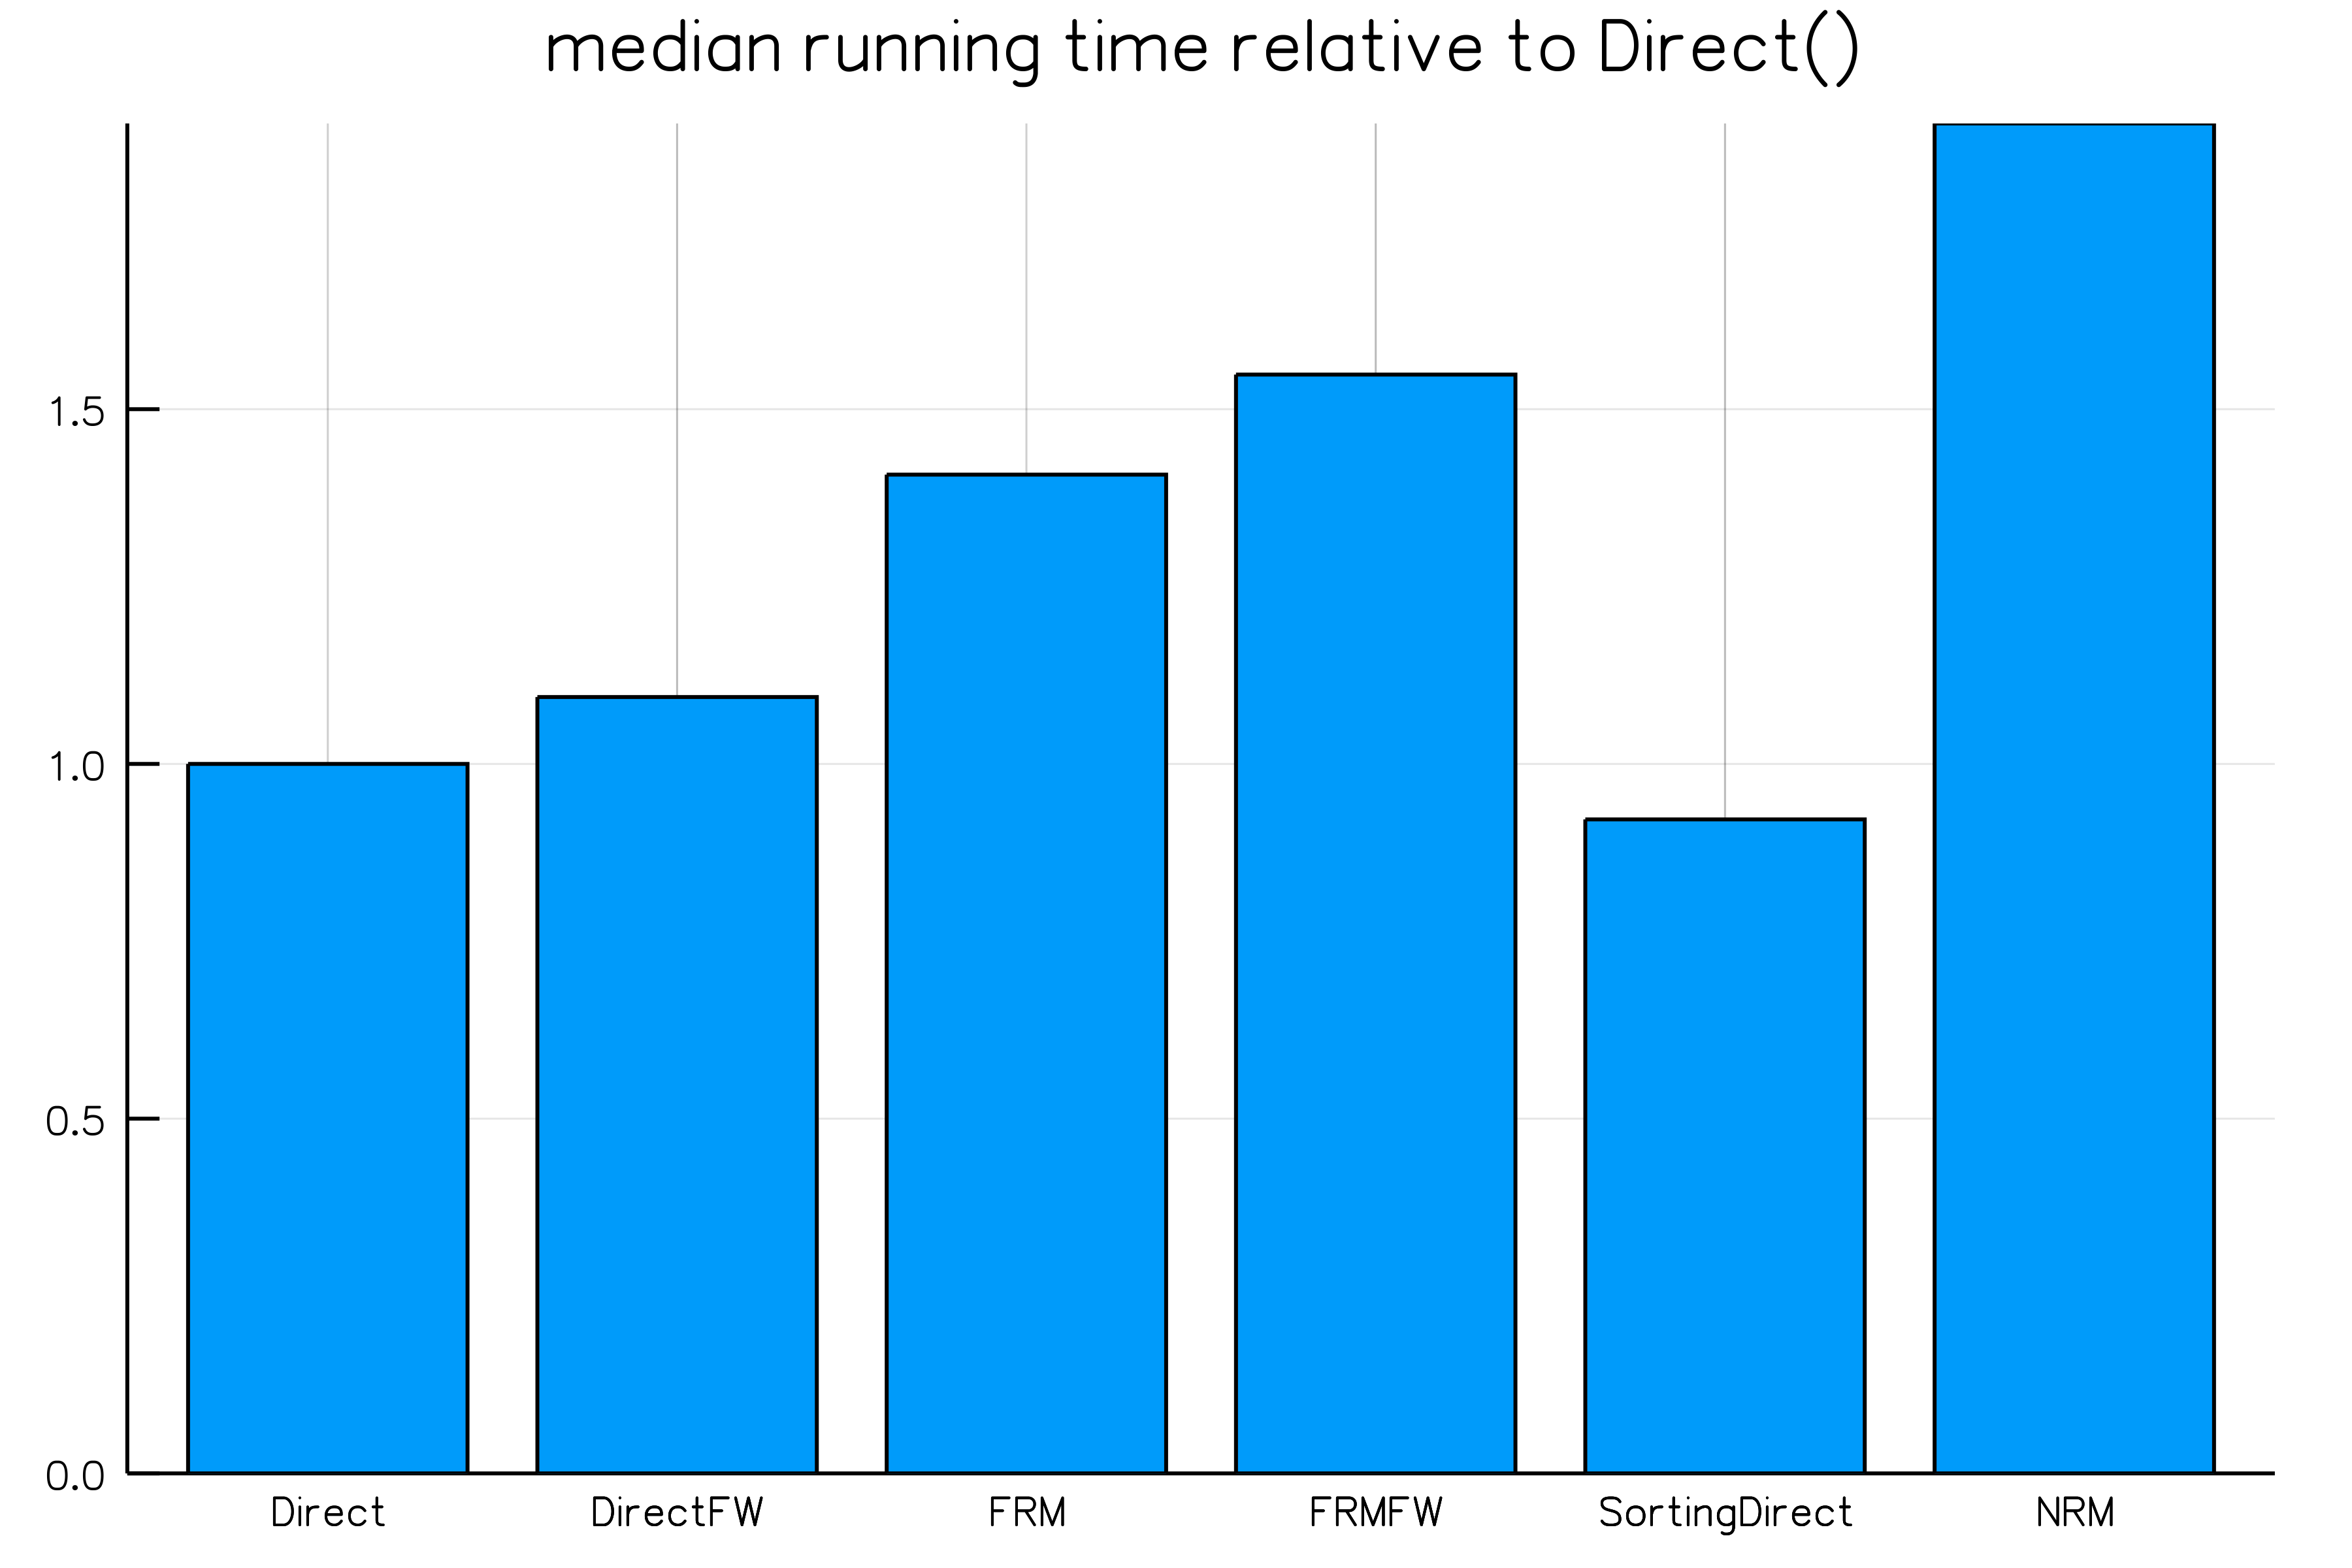

In [14]:
relmed = medtimes / medtimes[1]
bar(shortlabels,relmed,title="median running time relative to Direct()",leg=false,format=fmt)